In [1]:
# %%
import geopandas as gpd 
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
from scipy.interpolate import griddata
import py3dep as py3d

In [2]:
basin = "TuolumneRiver"

In [31]:
root_path = Path(f"/storage/dlhogan/summa_modeling_data/")

# open the CERES data
ceres_ds = xr.open_dataset(root_path / "CERES_SYN1deg-1H_Terra-Aqua-MODIS_Ed4_1_Subset_20000301-20240731.nc")

In [82]:
# open the basin shapefile
basin_gdf = gpd.read_file(root_path / f"domain_{basin}" / "shapefiles" / "catchment" / f"{basin}.shp")

# get a 1 degree dem from py3d
elev_1deg = py3d.get_map(["DEM"], basin_gdf.buffer(2).geometry[0], 4000, geo_crs=4326, crs=5070)

/tmp/ipykernel_24702/2417049275.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  elev_1deg = py3d.get_map(["DEM"], basin_gdf.buffer(2).geometry[0], 4000, geo_crs=4326, crs=5070)


In [33]:
# subset the data to the time period of interest
period = slice("2021-10-01", "2023-09-30")
ceres_ds = ceres_ds.sel(time=period)

# subtract 360 from the longitude
ceres_ds = ceres_ds.assign_coords(lon=ceres_ds.lon - 360)

# rename lat to y and lon to x
ceres_ds = ceres_ds.rename({"lat": "y", "lon": "x"})

In [34]:
new_time = ceres_ds.time.to_pandas().resample("1h").mean().index

# replace the time coordinate with the new time
ceres_ds = ceres_ds.assign_coords(time=new_time)

In [36]:
# broadband shortwave down
broadband_shortwave_down = ceres_ds['adj_sfc_sw_down_band_sw1_7_1h'] + ceres_ds['adj_sfc_sw_down_band_sw8_10_1h'] + \
                           ceres_ds['adj_sfc_sw_down_band_sw11_13_1h'] + ceres_ds['adj_sfc_sw_down_band_sw14_18_1h']

# broadband shortwave up
broadband_shortwave_up = ceres_ds['adj_sfc_sw_up_band_sw1_7_1h'] + ceres_ds['adj_sfc_sw_up_band_sw8_10_1h'] + \
                         ceres_ds['adj_sfc_sw_up_band_sw11_13_1h'] + ceres_ds['adj_sfc_sw_up_band_sw14_18_1h']

# broadband longwave down
broadband_longwave_down = ceres_ds['adj_sfc_lw_down_band_lw1_4_1h'] + ceres_ds['adj_sfc_lw_down_band_lw5_7_1h'] + ceres_ds['adj_sfc_lw_down_band_lw8_9_1h'] + \
                           ceres_ds['adj_sfc_lw_down_band_lw10_11_1h'] + ceres_ds['adj_sfc_lw_down_band_lw12_1h']
 
# broadband longwave up
broadband_longwave_up = ceres_ds['adj_sfc_lw_up_band_lw1_4_1h'] + ceres_ds['adj_sfc_lw_up_band_lw5_7_1h'] + ceres_ds['adj_sfc_lw_up_band_lw8_9_1h'] + \
                         ceres_ds['adj_sfc_lw_up_band_lw10_11_1h'] + ceres_ds['adj_sfc_lw_up_band_lw12_1h']

def add_crs_and_clip(ds, basin_gdf):
    """
    Add CRS to the dataset and clip it to the basin geometry.
    """
    # add crs
    ds = ds.rio.write_crs(basin_gdf.crs)
    
    # clip to the basin
    ds = ds.rio.clip_box(*basin_gdf.buffer(1).total_bounds, allow_one_dimensional_raster=True)
    
    return ds

ceres_ds.close()

In [37]:
broadband_longwave_down = add_crs_and_clip(broadband_longwave_down, basin_gdf)
broadband_longwave_up = add_crs_and_clip(broadband_longwave_up, basin_gdf)
broadband_shortwave_down = add_crs_and_clip(broadband_shortwave_down, basin_gdf)
broadband_shortwave_up = add_crs_and_clip(broadband_shortwave_up, basin_gdf)

/tmp/ipykernel_24702/3577135439.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ds = ds.rio.clip_box(*basin_gdf.buffer(1).total_bounds, allow_one_dimensional_raster=True)
/tmp/ipykernel_24702/3577135439.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ds = ds.rio.clip_box(*basin_gdf.buffer(1).total_bounds, allow_one_dimensional_raster=True)
/tmp/ipykernel_24702/3577135439.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ds = ds.rio.clip_box(*basin_gdf.buffer(1).total_bounds, allow_one_dimensional_raster=True)
/tmp/ipykernel_24702/3577135439.py:25: UserWarning: Geo

In [39]:
broadband_net_shortwave = broadband_shortwave_down - broadband_shortwave_up
broadband_net_longwave = broadband_longwave_down - broadband_longwave_up

In [40]:
gridmet_dem_4km = xr.open_dataset(root_path / "gridmet_metdata_elevationdata.nc")['elevation']
# add crs 
gridmet_dem_4km = gridmet_dem_4km.rio.write_crs("epsg:4326")
# rename lat to y and lon to x
gridmet_dem_4km = gridmet_dem_4km.rename({"lat": "y", "lon": "x"})
# clip to the basin
gridmet_dem_4km = gridmet_dem_4km.rio.clip_box(*basin_gdf.total_bounds)


In [41]:
# extract coordinates
lon_ceres, lat_ceres = np.meshgrid(broadband_longwave_down.x, broadband_longwave_down.y)
lon_gridmet, lat_gridmet = np.meshgrid(gridmet_dem_4km.x, gridmet_dem_4km.y)

# Flatten coordinate arrays for kriging input
points_ceres = np.array([lon_ceres.flatten(), lat_ceres.flatten()]).T
points_gridmet = np.array([lon_gridmet.flatten(), lat_gridmet.flatten()]).T

In [83]:
# reproject match to broadband longwave down
elev_1deg = elev_1deg.rio.reproject_match(broadband_longwave_down)

In [84]:
# ---- Vectorized Interpolation ----
def vectorized_downscaling(data_1deg, elev_4km, elev_adjust=False, method='cubic'):
    """
    Performs vectorized downscaling using bicubic interpolation and elevation correction.
    """
    time_steps = len(data_1deg['time'])
    W_values = data_1deg.values.reshape(time_steps, -1)  # Flatten W over space

    # Perform bicubic interpolation for all time steps
    interpolated_W = np.stack([
        griddata(points_ceres, W_values[t, :], (lon_gridmet, lat_gridmet), method=method)
        for t in range(time_steps)
    ])

    # Interpolate elevation
    interpolated_elev_1deg = griddata(points_ceres, elev_1deg.values.flatten(), (lon_gridmet, lat_gridmet), method=method)
        
    if elev_adjust:
         # Elevation difference (km)
        delta_elev_km = (elev_4km - interpolated_elev_1deg) / 1000.0
        # Apply elevation-based correction (-29 W/m² per km) taken from Hinkelman et al. (2013)
        interpolated_W = interpolated_W - (29 * delta_elev_km.values)

    return interpolated_W


In [94]:
# Apply vectorized downscaling
broadband_longwave_up_downscaled = vectorized_downscaling(broadband_longwave_up, gridmet_dem_4km, elev_adjust=True)
broadband_longwave_down_downscaled = vectorized_downscaling(broadband_longwave_down, gridmet_dem_4km, elev_adjust=False, method='nearest')
broadband_shortwave_up_downscaled = vectorized_downscaling(broadband_shortwave_up, gridmet_dem_4km, elev_adjust=False,method='nearest')
broadband_shortwave_down_downscaled = vectorized_downscaling(broadband_shortwave_down, gridmet_dem_4km, elev_adjust=False,method='nearest')

In [95]:
# convert to xr.DataArray
broadband_longwave_up_downscaled_ds = xr.DataArray(broadband_longwave_up_downscaled, dims=["time", "y", "x"], coords=[new_time, gridmet_dem_4km.y, gridmet_dem_4km.x])
broadband_longwave_down_downscaled_ds = xr.DataArray(broadband_longwave_down_downscaled, dims=["time", "y", "x"], coords=[new_time, gridmet_dem_4km.y, gridmet_dem_4km.x])
broadband_shortwave_up_downscaled_ds = xr.DataArray(broadband_shortwave_up_downscaled, dims=["time", "y", "x"], coords=[new_time, gridmet_dem_4km.y, gridmet_dem_4km.x])
broadband_shortwave_down_downscaled_ds = xr.DataArray(broadband_shortwave_down_downscaled, dims=["time", "y", "x"], coords=[new_time, gridmet_dem_4km.y, gridmet_dem_4km.x])

# Bias correction for snow covered periods

This is a rudimentary example. Can get actual snow covered area and do this again to get accurate timespans.

In [96]:
# let's do a quick evalutation for the nearest point against SAIL sebs
# import SAIL sebs
w22_SAIL_sebs_ds = xr.open_dataset("/storage/dlhogan/synoptic_sublimation/sail_data/winter_21_22/sebs_20211001_20220930.nc")
w23_SAIL_sebs_ds = xr.open_dataset("/storage/dlhogan/synoptic_sublimation/sail_data/winter_22_23/sebs_20221001_20230930.nc")

# concat the two years
SAIL_sebs_ds = xr.concat([w22_SAIL_sebs_ds, w23_SAIL_sebs_ds], dim='time')

In [97]:
# create a point to get the closest ceres points using lat and lon variables in SAIL_sebs_ds
lon = SAIL_sebs_ds['lon'].values[0]
lat = SAIL_sebs_ds['lat'].values[0]

In [98]:
radiation_vars = ['down_short_hemisp', 'up_short_hemisp', 'down_long', 'up_long']
SAIL_sebs_sw_down = SAIL_sebs_ds['down_short_hemisp'].where(SAIL_sebs_ds['qc_down_short_hemisp'] == 0).resample(time='1h').mean().dropna('time')
SAIL_sebs_sw_up = SAIL_sebs_ds['up_short_hemisp'].where(SAIL_sebs_ds['qc_up_short_hemisp'] == 0).resample(time='1h').mean().dropna('time')
SAIL_sebs_lw_down = SAIL_sebs_ds['down_long'].where(SAIL_sebs_ds['qc_down_long'] == 0).resample(time='1h').mean().dropna('time')
SAIL_sebs_lw_up = SAIL_sebs_ds['up_long'].where(SAIL_sebs_ds['qc_up_long'] == 0).resample(time='1h').mean().dropna('time')

In [99]:
def bias_correction(model, obs, lat=lat, lon=lon, basin=basin):
    """
    Apply piecwise linear bias correction to correct during snowy months
    We define snowy months as Dec-May
    """
    # get the months
    months = obs.time.dt.month
    # get the indices for the snowy months
    snowy_months = (months >= 12) | (months <= 5)
    # get the obs and model data for the snowy months
    obs_snowy_months = obs.where(snowy_months, drop=True)
    model_snowy_months = model.where(snowy_months, drop=True).sel(time=obs_snowy_months.time).sel(x=lat, y=lon, method='nearest')
    
    if basin == "EastRiver":
        # get the linear relationship between the model and obs
        slope, intercept = np.polyfit(obs_snowy_months.values, model_snowy_months.values, 1)
    else:
        slope = 0.38945705967369193
        print('Using East River slope from SAIL-derived winter regression to correct snow covered data')
    # apply the linear relationship to the model data for only the snowy months
    bias_corrected_model = model.where(model.time.dt.month.isin([6,7,8,9,10,11]), model/slope)
    # return the corrected model data
    return bias_corrected_model

In [100]:
# bias correct broadband_shortwave_up_downscaled_ds
broadband_shortwave_up_downscaled_ds = bias_correction(broadband_shortwave_up_downscaled_ds, SAIL_sebs_sw_up)

Using East River slope from SAIL-derived winter regression to correct snow covered data


In [101]:
# save the data to domain_EastRiver/forcing/1_raw_data
broadband_shortwave_down_downscaled_ds.to_netcdf(root_path / f"domain_{basin}" / "forcing" / "1_raw_data" / "broadband_shortwave_down_1h.nc")
broadband_shortwave_up_downscaled_ds.to_netcdf(root_path / f"domain_{basin}" / "forcing" / "1_raw_data" / "broadband_shortwave_up_1h.nc")
broadband_longwave_down_downscaled_ds.to_netcdf(root_path / f"domain_{basin}" / "forcing" / "1_raw_data" / "broadband_longwave_down_1h.nc")
broadband_longwave_up_downscaled_ds.to_netcdf(root_path / f"domain_{basin}" / "forcing" / "1_raw_data" / "broadband_longwave_up_1h.nc")

# CERES Product Plotting Example

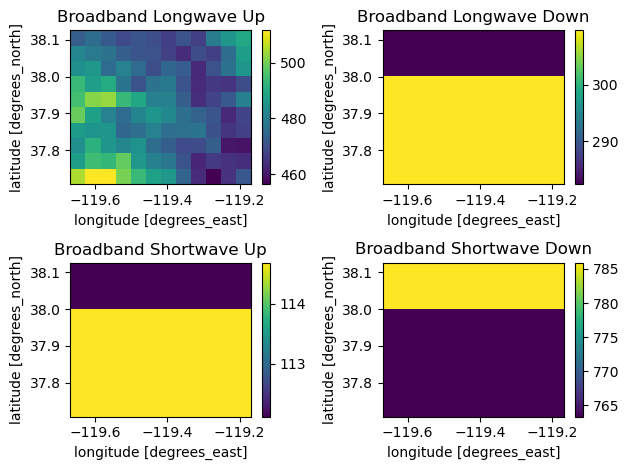

In [102]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2, tight_layout=True)

broadband_longwave_up_downscaled_ds.isel(time=20).plot(ax=axs[0, 0])
broadband_longwave_down_downscaled_ds.isel(time=20).plot(ax=axs[0, 1])
broadband_shortwave_up_downscaled_ds.isel(time=20).plot(ax=axs[1, 0])
broadband_shortwave_down_downscaled_ds.isel(time=20).plot(ax=axs[1, 1])

# add the relevant titles
for i, ax in enumerate(axs.flatten()):
    if i == 0:
        ax.set_title("Broadband Longwave Up")
    elif i == 1:
        ax.set_title("Broadband Longwave Down")
    elif i == 2:
        ax.set_title("Broadband Shortwave Up")
    elif i == 3:
        ax.set_title("Broadband Shortwave Down")



# CERES product evaluation

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def compute_metrics(obs, model):
    """Compute RMSE, Mean Bias, Correlation, and MAPE."""
    mask = ~np.isnan(obs) & ~np.isnan(model)  # Remove NaNs
    obs, model = obs[mask], model[mask]

    rmse = np.sqrt(np.mean((model - obs) ** 2))
    bias = np.mean(model - obs)
    correlation = np.corrcoef(obs, model)[0, 1]
    mape = np.mean(np.abs((model - obs).where(model>0) / obs.where(model>0))) * 100  # %
    slope = np.polyfit(obs, model, 1)[0]
    y_intercept = np.polyfit(obs, model, 1)[1]

    return rmse, bias, correlation, mape, slope, y_intercept

def add_metrics(ax, obs, model):
    """Add computed metrics as text to a plot."""
    rmse, bias, corr, mape, slope, y_intercept = compute_metrics(obs, model)
    metrics_text = f"RMSE: {rmse:.2f} W/m²\nBias: {bias:.2f} W/m²\nCorr: {corr:.2f}\nMAPE: {mape:.1f}%\nslope: {slope:.2f}\ny_intercept: {y_intercept:.2f}"
    ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

def plot_hexbin(ax, obs, model, xlabel, ylabel, gridsize=15):
    """Generate a hexbin plot with metrics and 1:1 reference line."""
    hb = ax.hexbin(obs, model, gridsize=gridsize, cmap='Blues', mincnt=1)

    # 1:1 reference line
    min_val, max_val = min(obs.min(), model.min()) - 15, max(obs.max(), model.max()) + 15
    ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

    # Add metrics
    add_metrics(ax, obs, model)

    # Labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    return hb  # Return hexbin object for shared colorbar

def plot_all_comparisons(dataset, time_slice=None):
    """
    Generate a 2×2 subplot hexbin comparison for all broadband radiation components.
    
    Parameters:
    dataset (dict): Dictionary containing datasets for each variable.
    """
    fig, axs = plt.subplots(2, 2, figsize=(8, 8), tight_layout=True)

    variables = ["lw_down", "lw_up", "sw_down", "sw_up"]
    labels = {
        "lw_down": ("SEBS Longwave Down (W/m²)", "CERES Longwave Down (W/m²)"),
        "lw_up": ("SEBS Longwave Up (W/m²)", "CERES Longwave Up (W/m²)"),
        "sw_down": ("SEBS Shortwave Down (W/m²)", "CERES Shortwave Down (W/m²)"),
        "sw_up": ("SEBS Shortwave Up (W/m²)", "CERES Shortwave Up (W/m²)"),
    }

    hexbin_objects = []  # To store hexbin objects for colorbar scaling
    
    for ax, var in zip(axs.flatten(), variables):
        sail_data = dataset[f"SAIL_{var}"]
        if time_slice is None:
            pass
        else:
            sail_data = sail_data.sel(time=sail_data.where(sail_data.time.dt.month.isin(time_slice),drop=True).time)
        broadband_data = dataset[f"broadband_{var}"].sel(y=dataset['lat'], x=dataset['lon'], method='nearest').sel(time=sail_data.time)

        hb = plot_hexbin(ax, sail_data, broadband_data, labels[var][0], labels[var][1])
        hexbin_objects.append(hb)

    # Add shared colorbar
    # cbar = fig.colorbar(hexbin_objects[0], ax=axs, orientation="horizontal", fraction=0.05, pad=0.1)
    # cbar.set_label("Data Density")

    plt.show()

def plot_comparison(dataset, variable):
    """
    Generate a 2×2 hexbin plot comparing SAIL and broadband data.

    Parameters:
    dataset (dict): Dictionary containing datasets for each variable.
    variable (str): Which variable to plot ('lw_down', 'lw_up', 'sw_down', 'sw_up').
    """
    fig, ax = plt.subplots(figsize=(5, 5))

    sail_data = dataset[f"SAIL_{variable}"]
    broadband_data = dataset[f"broadband_{variable}"].sel(y=dataset['lat'], x=dataset['lon'], method='nearest').sel(time=sail_data.time)

    labels = {
        "lw_down": ("SEBS Longwave Down (W/m²)", "CERES Longwave Down (W/m²)"),
        "lw_up": ("SEBS Longwave Up (W/m²)", "CERES Longwave Up (W/m²)"),
        "sw_down": ("SEBS Shortwave Down (W/m²)", "CERES Shortwave Down (W/m²)"),
        "sw_up": ("SEBS Shortwave Up (W/m²)", "CERES Shortwave Up (W/m²)"),
    }

    plot_hexbin(ax, sail_data, broadband_data, labels[variable][0], labels[variable][1])

    plt.tight_layout()
    plt.show()


Could conduct a piecewise linear adjustment

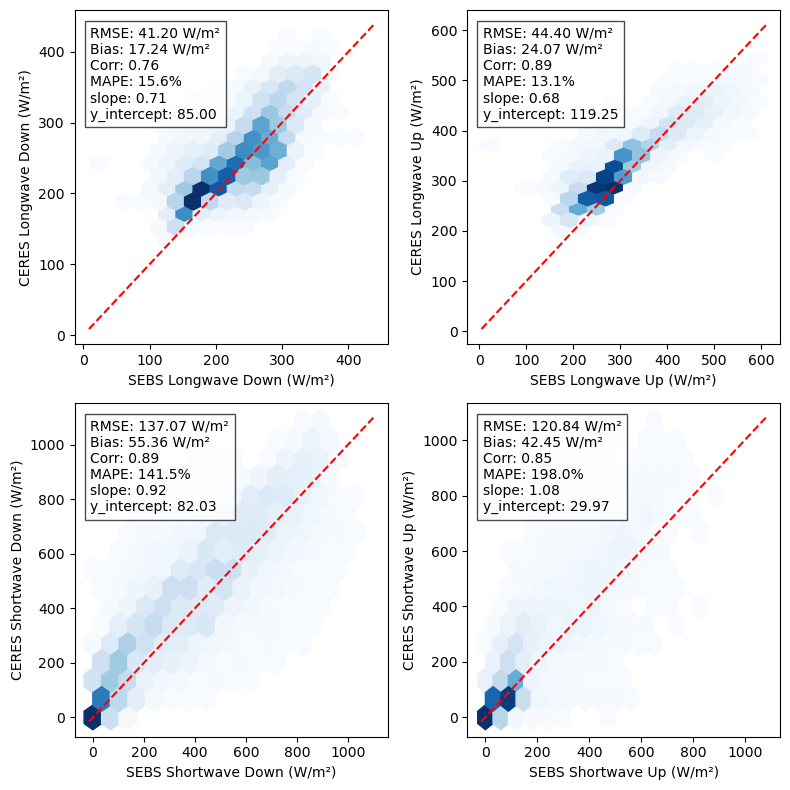

In [27]:
# only compute for EastRiver
if basin == "EastRiver":
    snow_season_slice = [12,1,2,3,4]
    mixed_season_slice = [10,11,5,6]
    warm_season_slice = [7,8,9]
    dataset = {
        "SAIL_lw_down": SAIL_sebs_lw_down,
        "broadband_lw_down": broadband_longwave_down_downscaled_ds,
        "SAIL_lw_up": SAIL_sebs_lw_up,
        "broadband_lw_up": broadband_longwave_up_downscaled_ds,
        "SAIL_sw_down": SAIL_sebs_sw_down,
        "broadband_sw_down": broadband_shortwave_down_downscaled_ds,
        "SAIL_sw_up": SAIL_sebs_sw_up,
        "broadband_sw_up": broadband_shortwave_up_downscaled_ds,
        "lat": lat,
        "lon": lon,
    }

    plot_all_comparisons(dataset)